In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [2]:
rerun = False
filename_end = ""
folder_name = "files/"

In [3]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


All frequencies are captured by the sampling rate.


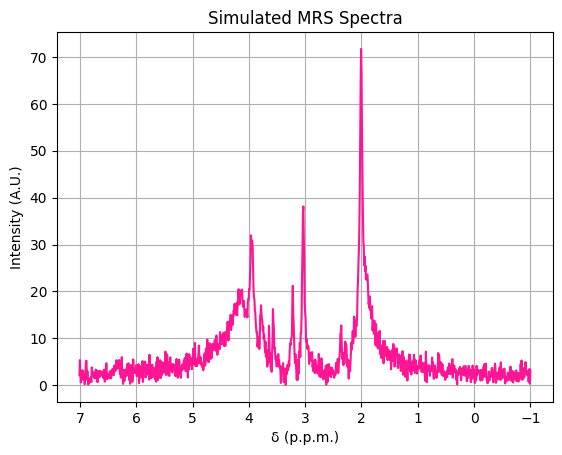

In [4]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig = pymri.corrupted_snr(sig, 0.0, 0.03)
c_freqs, c_sig_fft = pymri.fourier_spectrum( c_sig, dt, B0 )

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [5]:
L = np.arange(start = 0.2, stop = 0.8, step = 0.05)
noise_threshold = 1e-15
print(L)

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ]


In [6]:
reconstructed_sig, z, r = pymri.filter_sig( c_sig, 0.45, noise_threshold, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True )

In [7]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)

# s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)
# M_0s, spins_phi, ws, t2s = np.sort(M_0s), np.sort(spins_phi), np.sort(ws), np.sort(t2s)

In [8]:
# 1. NÃO ordenar a lista individualmente para preservar as posições de cada parâmetro
# 2. Criar um parâmtero \Delta que define o tamanho máximo do raio de filtragem ao redor das frequências de referência de um sinal limpo
# 3. Filtrar as frequências ao redor dessa frequencia central dentro desse raio máximo
Delta = 50

In [9]:
mask = np.full_like(omega, False, dtype=bool)

for i in range(ws.size):
    mask = np.bitwise_or(mask, np.bitwise_and(omega > ws[i] - Delta, omega <= ws[i] + Delta)) 

In [10]:
filtered_s0 = s0[mask]
filtered_phi = phi[mask]
filtered_omega = omega[mask]
filtered_alpha = alpha[mask]

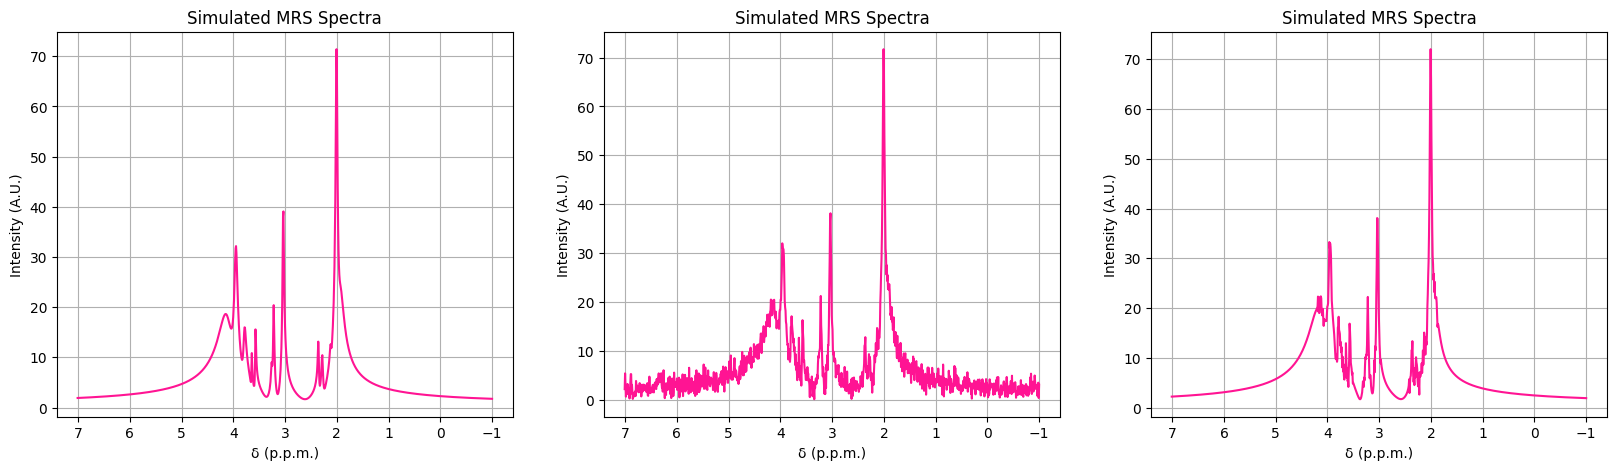

In [11]:
filtered_pop = pymri.population(filtered_omega, 1/filtered_alpha, filtered_s0, filtered_phi)

filtered_sig, t = pymri.population_transverse_decay(t0, tn, dt, filtered_pop, np.ndarray([]))

filtered_freqs, filtered_sig_fft = pymri.fourier_spectrum( filtered_sig, dt, B0 )

plt.figure(figsize = (20, 5))
plt.subplot(131)
pymri.plot_chem_shifts( freqs, sig_fft, 1.0 )

plt.subplot(132)
pymri.plot_chem_shifts( c_freqs, c_sig_fft, 1.0 )

plt.subplot(133)
pymri.plot_chem_shifts( filtered_freqs, filtered_sig_fft, 1.0 )